In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

KeyError: 'TBE_EPHEM_CREDS_ADDR'

In [ ]:
!unzip drive/MyDrive/tf/lego_dataset.zip -d /mnt/app_iot

In [ ]:
import tensorflow as tf
import warnings
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found')
else:
    print('Default GPU device: {}' .format(tf.test.gpu_device_name()))

Default GPU device: /device:GPU:0


In [ ]:
#Inicialización de los generadores de números aleatorios para reproducibilidad
# Valor de la semilla inicial
seed_value= 1

# 1. Definir la variable de entorno `PYTHONHASHSEED` a un valor dado
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Iniciar el generador de número aleatorios en `python`
# módulo random
import random
random.seed(seed_value)

# 3. Iniciar el generador de número aleatorios de `numpy`
import numpy as np
np.random.seed(seed_value)

# 4. Iniciar el generador de número aleatorios de `tensorflow`
import tensorflow as tf
tf.random.set_seed(seed_value) #tf.random.set.seed(seed_value)
################################################################################

#%% Red pre-entrenada ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

ROWS = 197 #150 #197
COLS = 197 #150 #197
CHANNELS = 3

train_dir  = "/mnt/app_iot/lego_dataset/train"
validation_dir = "/mnt/app_iot/lego_dataset/test"

#RED_TRANSFER='vgg16'
#RED_TRANSFER='resnet50'
RED_TRANSFER = 'v2l'
img_height,img_width = ROWS,COLS
num_clases = 50

if RED_TRANSFER=='vgg16':
    Red=applications.vgg16.VGG16(include_top=False,
              weights='imagenet',  input_shape=(img_height,img_width , CHANNELS ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        print(layer, layer.trainable)
elif RED_TRANSFER=='resnet50':
    Red = applications.resnet50.ResNet50(include_top=False,
              weights='imagenet',  input_shape=(img_height,img_width , CHANNELS ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
            layer.trainable = True
        print(layer, layer.trainable)
elif RED_TRANSFER=='v2l':
    Red = applications.EfficientNetV2B3(include_top=False,
              weights="imagenet",input_shape=(img_height,img_width , CHANNELS ))
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
          layer.trainable = True
        print(layer, layer.trainable)


<keras.src.engine.input_layer.InputLayer object at 0x7ff3a76307c0> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ff388a8a7a0> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7ff388a8b7c0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff388a8b130> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff3840981f0> True
<keras.src.layers.core.activation.Activation object at 0x7ff384098f40> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff38409a5c0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff3840997b0> True
<keras.src.layers.core.activation.Activation object at 0x7ff38409ad70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff38409bdc0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff36a7291e0> True
<keras.src.layers.core.activation.Activation ob

In [ ]:
model = Sequential()
model.add(Red)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_clases, activation='softmax'))
model.summary()

from tensorflow.keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               196736    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 50)               

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Instanciamos los generadores de datos con reescalado de 1./255.
train_datagen = ImageDataGenerator( preprocessing_function = preprocess_input)
#train_datagen = ImageDataGenerator(
      #preprocessing_function=preprocess_input,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest')

test_datagen  = ImageDataGenerator( preprocessing_function = preprocess_input )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(ROWS, COLS))
print(train_generator.class_indices)
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=128,
                                                         class_mode='categorical',
                                                         target_size=(ROWS, COLS))
print(train_generator.class_indices)

Found 30000 images belonging to 50 classes.
{'14719': 0, '15672': 1, '18654': 2, '2357': 3, '2420': 4, '2780': 5, '27925': 6, '3001': 7, '3002': 8, '3003': 9, '3004': 10, '3005': 11, '3010': 12, '3020': 13, '3021': 14, '3022': 15, '3023': 16, '3024': 17, '3037': 18, '3038': 19, '3039': 20, '3040': 21, '3045': 22, '3046': 23, '3062': 24, '3063': 25, '3068': 26, '3069': 27, '3070': 28, '3298': 29, '33909': 30, '3622': 31, '3623': 32, '3659': 33, '3675': 34, '3700': 35, '3794': 36, '4150': 37, '41677': 38, '41678': 39, '4274': 40, '4286': 41, '43093': 42, '43857': 43, '4490': 44, '54200': 45, '6143': 46, '6632': 47, '85984': 48, '99301': 49}
Found 10000 images belonging to 50 classes.
{'14719': 0, '15672': 1, '18654': 2, '2357': 3, '2420': 4, '2780': 5, '27925': 6, '3001': 7, '3002': 8, '3003': 9, '3004': 10, '3005': 11, '3010': 12, '3020': 13, '3021': 14, '3022': 15, '3023': 16, '3024': 17, '3037': 18, '3038': 19, '3039': 20, '3040': 21, '3045': 22, '3046': 23, '3062': 24, '3063': 25, '3

In [ ]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=150,
                              epochs=100,
                              validation_steps=50,
                              verbose=1)

#%% Fit tarda unos 15 min / 30 min
#history=model.fit(X_train, Y_train, epochs = 10, batch_size = 32,
#                  validation_data=(X_test,Y_test),
#                  verbose=1)

Epoch 1/100
150/150 [==============================] - 102s 676ms/step - loss: 3.5416 - accuracy: 0.1183 - val_loss: 2.9416 - val_accuracy: 0.3237
Epoch 2/100
150/150 [==============================] - 99s 656ms/step - loss: 2.8163 - accuracy: 0.2717 - val_loss: 2.1335 - val_accuracy: 0.4780
Epoch 3/100
150/150 [==============================] - 99s 659ms/step - loss: 2.2967 - accuracy: 0.3531 - val_loss: 1.6776 - val_accuracy: 0.5778
Epoch 4/100
150/150 [==============================] - 98s 653ms/step - loss: 1.9936 - accuracy: 0.4156 - val_loss: 1.4289 - val_accuracy: 0.6317
Epoch 5/100
150/150 [==============================] - 116s 773ms/step - loss: 1.8100 - accuracy: 0.4582 - val_loss: 1.2807 - val_accuracy: 0.6542
Epoch 6/100
150/150 [==============================] - 99s 659ms/step - loss: 1.6729 - accuracy: 0.4914 - val_loss: 1.1591 - val_accuracy: 0.6836
Epoch 7/100
150/150 [==============================] - 98s 654ms/step - loss: 1.5604 - accuracy: 0.5176 - val_loss: 1.0567

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 37s 458ms/step - loss: 0.2669 - accuracy: 0.9025
Test loss: 0.2669088542461395
Test accuracy: 0.9024999737739563


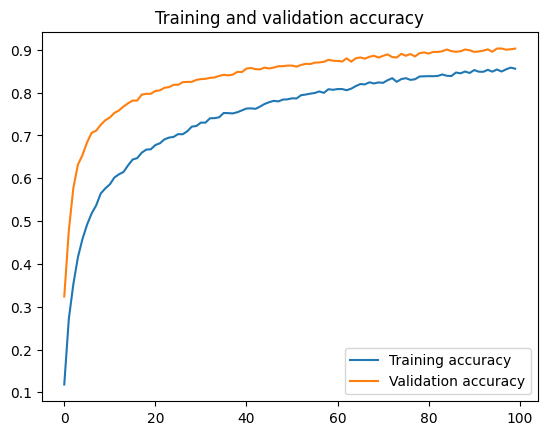

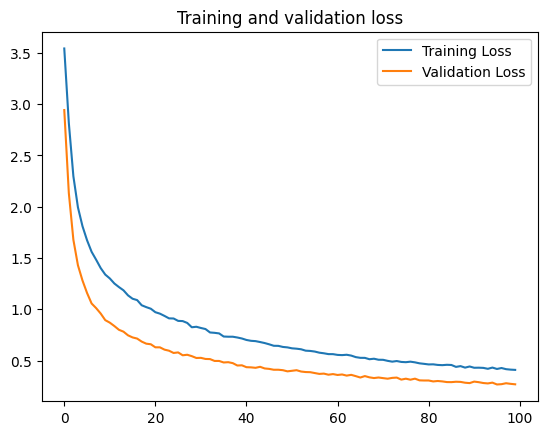

In [ ]:
# Evolución de Accuracy and Loss para el modelo
# Valores de training y validation
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) #Número de epochs

#------------------------------------------------
# Dibujar training y validation accuracy en cada epoch
#------------------------------------------------
plt.plot  ( epochs,     acc ,  label='Training accuracy')
plt.plot  ( epochs, val_acc , label='Validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Dibujar training y validation loss en cada epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label='Training Loss')
plt.plot  ( epochs, val_loss ,  label='Validation Loss')
plt.title ('Training and validation loss'   )
plt.legend()

plt.show()

model.save_weights('/mnt/app_iot/Lego-efficientv2-100epoc-150steps-noaugmentation-batch128.h5')
#model.load_weights('/mnt/app_iot/Lego-e-30epoc2.h5')

In [ ]:
###############################################################################################################

## Inferencia de la red neuronal

In [ ]:
#%% Se carga la red neuronal y sus pesos
#Inicialización de los generadores de números aleatorios para reproducibilidad
# Valor de la semilla inicial
seed_value= 1

# 1. Definir la variable de entorno `PYTHONHASHSEED` a un valor dado
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Iniciar el generador de número aleatorios en `python`
# módulo random
import random
random.seed(seed_value)

# 3. Iniciar el generador de número aleatorios de `numpy`
import numpy as np
np.random.seed(seed_value)

# 4. Iniciar el generador de número aleatorios de `tensorflow`
import tensorflow as tf
tf.random.set_seed(seed_value) #tf.random.set.seed(seed_value)
################################################################################

#%% Red pre-entrenada ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

ROWS = 197 #150 #197
COLS = 197 #150 #197
CHANNELS = 3

#RED_TRANSFER='vgg16'
#RED_TRANSFER='resnet50'
RED_TRANSFER = 'v2l'
img_height,img_width = ROWS,COLS
num_clases = 50

dir_pesos = "/mnt/app_iot/Lego-efficientv2-100epoc-150steps-noaugmentation-batch128.h5"
if RED_TRANSFER=='vgg16':
    Red=applications.vgg16.VGG16(include_top=False,
              weights='imagenet',  input_shape=(img_height,img_width , CHANNELS ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        print(layer, layer.trainable)
elif RED_TRANSFER=='resnet50':
    Red = applications.resnet50.ResNet50(include_top=False,
              weights='imagenet',  input_shape=(img_height,img_width , CHANNELS ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
            layer.trainable = True
        print(layer, layer.trainable)
elif RED_TRANSFER=='v2l':
    Red = applications.EfficientNetV2B3(include_top=False,
              weights="imagenet",input_shape=(img_height,img_width , CHANNELS ))
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
          layer.trainable = True
        print(layer, layer.trainable)

model = Sequential()
model.add(Red)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_clases, activation='softmax'))
model.summary()

from tensorflow.keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

## Cargamos los pesos del modelo
model.load_weights(dir_pesos)

#%% Guardamos todo el modelo
#dir_modelo = "/mnt/app_iot/save_modelo_v1.keras"
#model.save(dir_modelo)

<keras.src.engine.input_layer.InputLayer object at 0x7fd2e3e93940> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd2e3e91b40> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7fd2e3e93b20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd2e3e90d90> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd2e3e91a20> True
<keras.src.layers.core.activation.Activation object at 0x7fd2e3e92440> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd2e3e915d0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd2e43628c0> True
<keras.src.layers.core.activation.Activation object at 0x7fd2e3e90520> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd2e4363190> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd2e43631f0> True
<keras.src.layers.core.activation.Activation ob

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>

# Guardar a TF lite


In [ ]:
#%% Guardamos todo el modelo
dir_modelo = "/mnt/app_iot/save_modelo_v1"
#tf.saved_model.save(model, dir_modelo)
#model.export(dir_modelo)

In [ ]:
## Convertimos el modelo guardado a tf_lite
# Convert the model
dir_modelo = "/mnt/app_iot/save_modelo_v1"
converter = tf.lite.TFLiteConverter.from_saved_model(dir_modelo) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/mnt/app_iot/save_modelo_v1/model.tflite', 'wb') as f:
  f.write(tflite_model)

<bound method Image.getchannel of <PIL.Image.Image image mode=RGB size=197x197 at 0x7F0E40405EA0>>


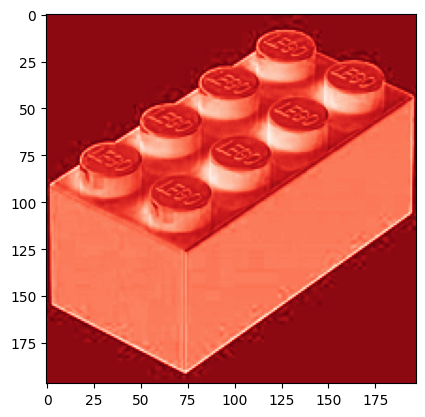

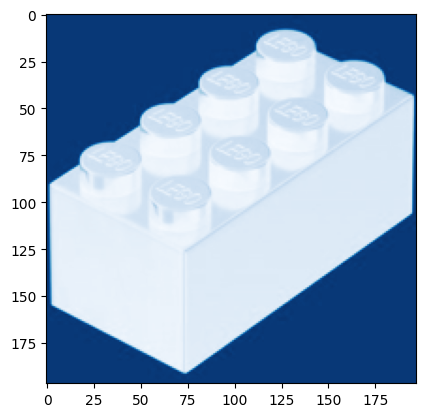

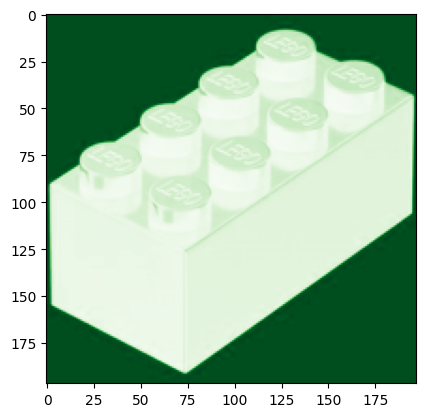

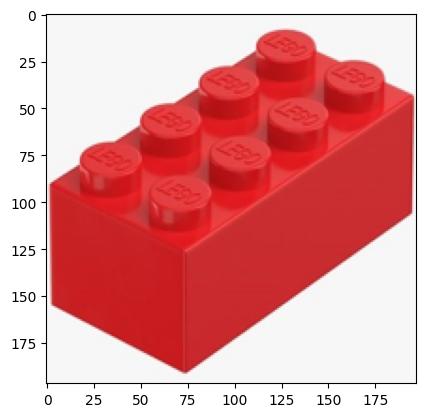

[  1 197 197   3]


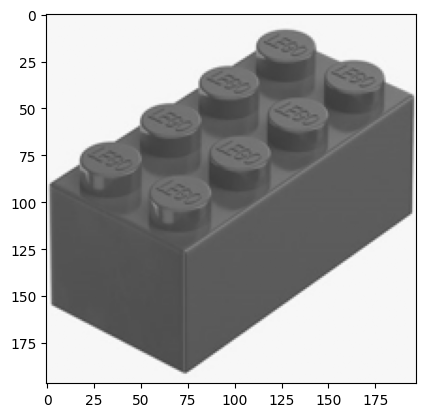

(1, 197, 197, 3)
(1, 197, 197, 3)
149.061
152.5
(197, 197, 3)
(1, 197, 197, 3)
7
0.98594


In [ ]:
import os
import urllib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.imagenet_utils import preprocess_input

#Pillo la imagen y la convierto a algo que puedan leer
dir_imagen = "/mnt/app_iot/imagenes_prueba/fotos_wenas/brick 2x4_2.jpg"
#dir_imagen = "/mnt/app_iot/dataset/3002 brick 2x3 108L.png"
color = Image.open(dir_imagen).convert('RGB').resize((197,197))
gray = Image.open(dir_imagen).convert('L').resize((197,197))
imagen = np.zeros((197, 197, 3))
imagen[:, :, 0] = gray
imagen[:, :, 1] = gray
imagen[:, :, 2] = gray
print(color.getchannel)
color_2 = np.array(color, dtype=np.float32)
plt.imshow((color_2[:, :, 0]/255.), cmap='Reds')
plt.show()
plt.imshow((color_2[:, :, 1]/255.), cmap='Blues')
plt.show()
plt.imshow((color_2[:, :, 2]/255.), cmap='Greens')
plt.show()
plt.imshow(color_2/255.)
plt.show()

interpreter = tf.lite.Interpreter(model_path="/mnt/app_iot/save_modelo_v1/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
print(input_shape)
input_data = np.array(imagen, dtype=np.float32)
plt.imshow(input_data/255.)
plt.show()


input_data2 = np.expand_dims(input_data, axis=0)
input_data2_cp = np.copy(input_data2)
x = preprocess_input(input_data2)

aux_inp = input_data2_cp[0][:, :, 0]
input_data2_cp[0][:, :, 0] = input_data2_cp[0][:, :, 2]
input_data2_cp[0][:, :, 2] = aux_inp
input_data2_cp = input_data2_cp-100.5
#x2 = tf.transpose(input_data2_cp, [0, 3, 1, 2])
x2 = input_data2_cp
#print(np.max(input_data2_cp))
print(np.shape(x))
print(np.shape(x2))
print(np.max(x))
print(np.max(x2))
print(np.shape(input_data))
print(np.shape(input_data2))

interpreter.set_tensor(input_details[0]['index'], x)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = output_data.argmax()
print(prediction)
print(output_data[0, prediction])



TypeError: Invalid shape (1, 197, 197, 3) for image data

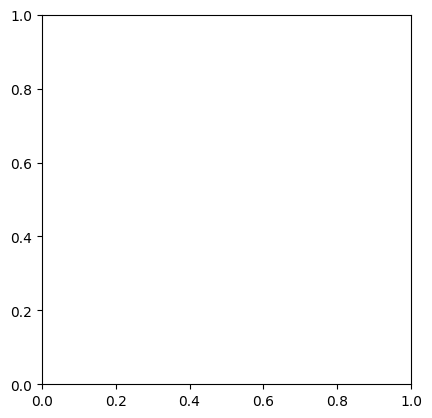

In [ ]:
import keras
import matplotlib.pyplot as plt
img_path = '/mnt/app_iot/lego2.png'
#img = keras.utils.load_img(img_path, target_size=(ROWS, COLS))
#x = keras.utils.img_to_array(img)
img = Image.open(dir_imagen).convert('RGB').resize((197,197))
x_prev = x
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(np.array(x[0])/255. +0.5)
plt.show()
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print(preds)
prediction = output_data.argmax()
print(prediction)
#print('Predicted:', decode_predictions(preds, top=3)[0])


In [ ]:
import cv2
cv2.imshow(x)

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow
